# Latam Airlines' Data Scientist Challenge Solution

- Author: Javier Welch (welch.javier[at]gmail.com)
- Date: January 13th, 2023

### Contents

0. Imports and Preprocessing
1. Question 1: How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?
2. Question 2: Generate additional columns and export them to a CSV file.
3. Question 3: What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight?What variables would you expect to have the most influence in predicting delays?
4. Question 4: Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.
5. Question 5: Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in the prediction task? How could you improve the Performance?

## 0. Imports and Preprocessing

In [6]:
# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from utils import *

%matplotlib inline

In [7]:
# Data import
data = pd.read_csv('../data/dataset_SCL.csv')

/var/folders/d6/r774t3wj5s77bz4nbvb4xwr40000gn/T/ipykernel_5696/2604435694.py:2: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/dataset_SCL.csv')


In [8]:
#Check data structure
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [9]:
#Check data types and non-nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [10]:
#Check for extra missind values
data.isna().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

There are 2 date columns that should be parsed ("Fecha-I" & "Fecha-O") and a missing value in the "Vlo-O" column.

In [11]:
#Parse Fecha columns
date_columns = ["Fecha-I", "Fecha-O"]
for col in date_columns:
    data[col] = pd.to_datetime(data[col])

In [12]:
#Identify missing value
#Flight Operation Number can be identified by 
row_missing_value = data[data['Vlo-O'].isna()]
row_missing_value

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


In [13]:
#Missing Flight Operation Number corresponds to a LAW flight from SCEL to SPJC scheduled for Thursdays at 11:00, let's check if there's a matching record
matching_records = data[(data['Fecha-I'].dt.hour == row_missing_value['Fecha-I'].dt.hour.iloc[0]) 
    & (data['Emp-I'] == row_missing_value['Emp-I'].iloc[0]) 
    & (data['Ori-O'] == row_missing_value['Ori-O'].iloc[0]) 
    & (data['Des-O'] == row_missing_value['Des-O'].iloc[0]) 
    & (data['DIANOM'] == row_missing_value['DIANOM'].iloc[0]) 
    & ~(data['Vlo-O'].isna())]

matching_records['Vlo-O'].value_counts()

200    26
Name: Vlo-O, dtype: int64

In [14]:
#Flight Operation Number was supposed to be 200, let's patch it
data.loc[row_missing_value.index, 'Vlo-O'] = matching_records['Vlo-O'].value_counts().index[0]
data.loc[row_missing_value.index, 'Vlo-O']

6068    200
Name: Vlo-O, dtype: object

### 1. Question 1: How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

Firstly, it is impotant to note that all flights in the dataset depart from Santiago (SCL). From this starting point we can start drilling down using different criteria to analyze the data:
- There are 23 different operators flying from SCL. However, there are only 4 airlines operating domestic flights, with Grupo LATAM being the market leader having operated 64% of all domestic flights, followed far behind by Sky Airline with a share of 31%. International flights incorporate more competitors but Grupo LATAM still emerges as the top operator with a share of 55% of flights, while all other operators had shares of less than 10%. 

- Looking at the distribution of flights by destination, we can see that the there are 62 unique destinations for flights departing from SCL. In spite of that, the number of flights by destination is fairly concentrated, with the top 10 destinations representing 67% of the total flight volume. The top 5 destinations are Buenos Aires, Antofagasta, Lima, Calama and Puerto Montt.

- When inspecting the data by kind of flight (domestic v/s international), we see that domestics flights represent 54% of the total flight volume. Analyzing the yearly seasonality of domestic and international flights we discover that both kinds of flights have peaks during the summer and July (high-seasons) but domestic flights experience sharper declines during the first semesters off-season, suggesting that the share of vacational travelers is higher throughout the year for domestic flights when compared to international flights. Digging deeper into weekly and daily seasonality, we find that there is a sharp decline in domestic flight numbers during Saturdays and that they tend to concentrate in the 6:00-8:00 and 17:00-19:00 periods, indicating that there is a larger share of work related flights. On the other hand, international flights tend to have a flatter weekly distribution but trending higher during weekends. Lastly, international flights have a larger proportion of nighttime flights due to their longer duration.

- When looking at selected destinations (namely, Buenos Aires, Antofagasta, Calama, Puerto Montt, Miami & Madrid), we confirm our previous findings for domestic destinations but with a marked distinction between cities located in the North and South of Chile, being the first ones more affected by their high share of work related flights, following the yearly pattern of mining activity (upward trending during the second semester). Looking at international destinations, we see that flights to Buenos Aires are fairly stable during the year and week and probably cater to working and vacational travelers with peaks during the morning (6:00-9:00), at 16:00 (return of Argentinian workers and pick up of Chilean workers around 18:00-19:00) and at 21:00 (return of Argentinian vacationers and pick up of Chilean vacationers around 23:00). Flights to Miami trend higher during summer and typically depart between 21:00 and 23:00 in order to arrive early in ther morning, while flights to Madrid tend to peak during the European summer and have two hourly clusters: around noon for European flights returning home (operated by Iberia) and around 19:00 for flights whose home base is Chile (operated by Grupo LATAM).

In [15]:
#Flight origin, all flights depart from Santiago
data['SIGLAORI'].value_counts()

Santiago    68206
Name: SIGLAORI, dtype: int64

In [16]:
#Number of airlines
data['OPERA'].nunique()

23

In [17]:
#Share of flights by airline and kind
pivot_airlines_kind = pd.pivot_table(data = data, values = 'DIA', index = ['OPERA'], columns=['TIPOVUELO'], aggfunc = 'count', fill_value = 0)
pivot_airlines_kind = pivot_airlines_kind/pivot_airlines_kind.sum()*100
pivot_airlines_kind = pivot_airlines_kind.reset_index()

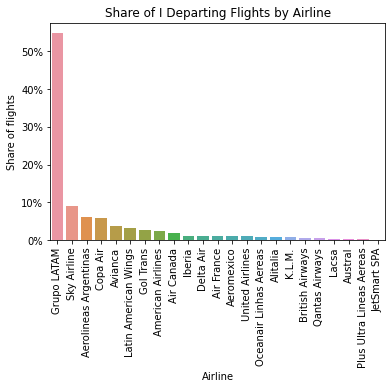

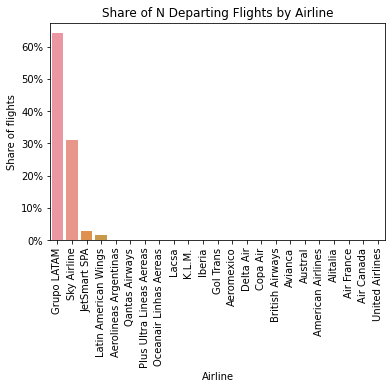

In [18]:
#Plot share of flights by airline and kind
for kind in ['I', 'N']:
    fig = sns.barplot(data=pivot_airlines_kind.sort_values(kind, ascending=False), x='OPERA', y=kind)
    fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
    fig.yaxis.set_major_formatter(mtick.PercentFormatter())
    fig.set_title(f"Share of {kind} Departing Flights by Airline")
    fig.set_ylabel("Share of flights")
    fig.set_xlabel("Airline")
    plt.show()

In [19]:
#Unique Flight destinations
data['SIGLADES'].nunique()

62

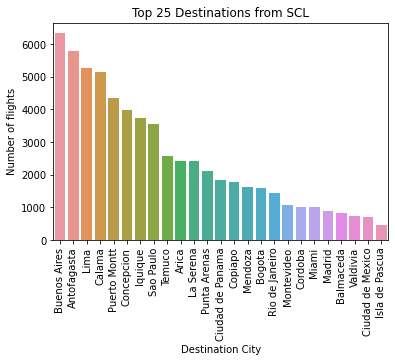

In [20]:
#Plot number of Flights by destination
fig = sns.countplot(data=data, 
            x = 'SIGLADES',
            order = data['SIGLADES'].value_counts().iloc[:25].index)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig.set_title("Top 25 Destinations from SCL")
fig.set_ylabel("Number of flights")
fig.set_xlabel("Destination City")
plt.show()

In [21]:
#Cumulative share of flights, fairly concentrated, 10 destinations represent nearly 70% of outbound flights
vc_destinations = data['SIGLADES'].value_counts(normalize = True)
vc_destinations = vc_destinations.cumsum()
vc_destinations = vc_destinations.reset_index(drop=True)
vc_destinations.head(15)


0     0.092880
1     0.177712
2     0.254978
3     0.330425
4     0.394305
5     0.452849
6     0.507785
7     0.560112
8     0.598071
9     0.633786
10    0.669120
11    0.699982
12    0.727106
13    0.753204
14    0.777028
Name: SIGLADES, dtype: float64

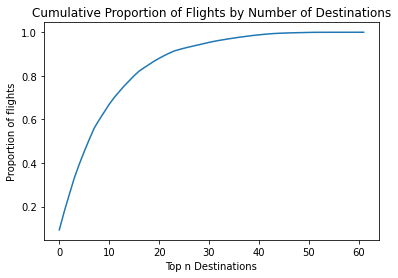

In [22]:
#Plot cumulative share of flight by destination
fig = sns.lineplot(data = vc_destinations)
fig.set_title('Cumulative Proportion of Flights by Number of Destinations')
fig.set_ylabel('Proportion of flights')
fig.set_xlabel('Top n Destinations')
plt.show()

In [23]:
#Share of flights by kind
vc_flight_kind = data['TIPOVUELO'].value_counts(normalize=True)
vc_flight_kind

N    0.541976
I    0.458024
Name: TIPOVUELO, dtype: float64

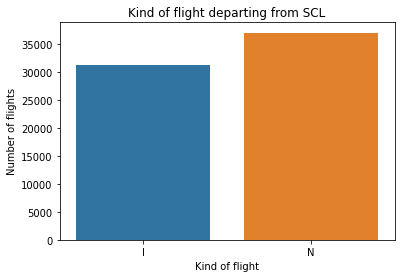

In [24]:
#Count of Domestic vs International Flights, not much difference overall
fig = sns.countplot(data = data, x= 'TIPOVUELO')
fig.set_title("Kind of flight departing from SCL")
fig.set_ylabel("Number of flights")
fig.set_xlabel("Kind of flight")
plt.show()

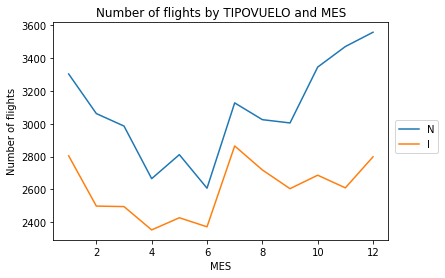

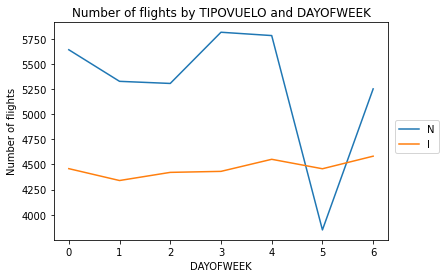

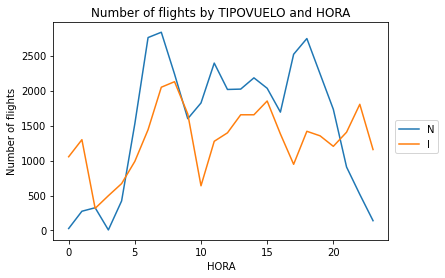

In [25]:
#Generate HORA and DAYOFWEEK column based on flight scheduled date
data['HORA'] = data['Fecha-I'].dt.hour
data['DAYOFWEEK'] = data['Fecha-I'].dt.dayofweek

time_columns = ['MES', 'DAYOFWEEK', 'HORA']

#Seasonality of domestic vs international flights

for time_col in time_columns:
    get_flight_seasonality_graph(data, time_col, 'TIPOVUELO')


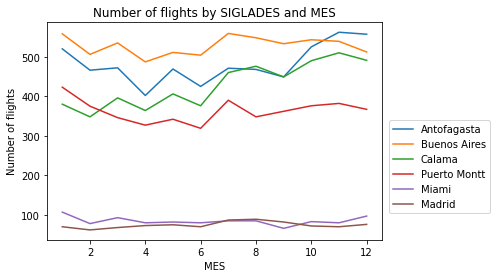

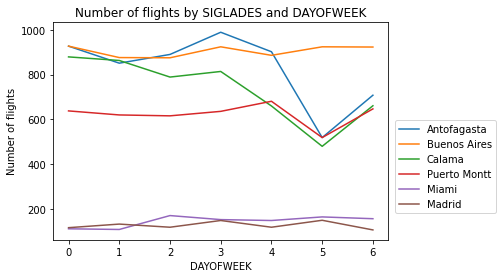

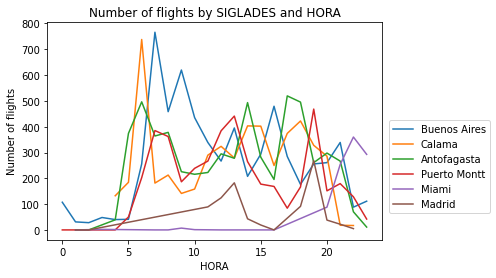

In [26]:
#Seasonality of selected destinations

destinations = ['Buenos Aires', 'Antofagasta', 'Calama', 'Puerto Montt', 'Miami', 'Madrid']

data_subset = data[data['SIGLADES'].isin(destinations)]

for time_col in time_columns:
    get_flight_seasonality_graph(data_subset, time_col, 'SIGLADES')

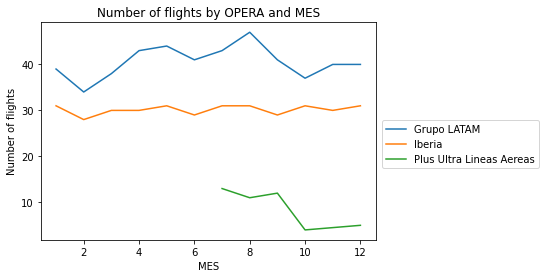

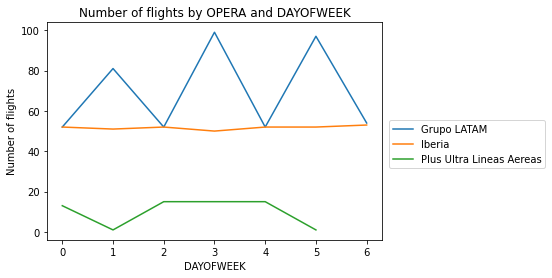

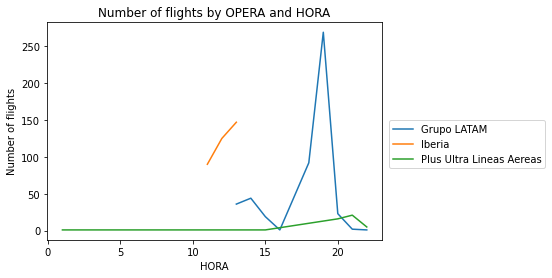

In [27]:
#Madrid bound flights by Airline
destinations = ['Madrid']

data_subset = data[data['SIGLADES'].isin(destinations)]

for time_col in time_columns:
    get_flight_seasonality_graph(data_subset, time_col, 'OPERA')

### 2. Question 2: Generate additional columns and export them to a CSV file.

In [28]:
#Generate high_season column:
#1 if Fecha-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
mask_high_season = (
                    ((data['Fecha-I'].dt.month == 12) &  (data['Fecha-I'].dt.day >= 15)) |    #Days between Dec-15 and Dec-31
                    (data['Fecha-I'].dt.month <= 2)                                      |    #January and February
                    ((data['Fecha-I'].dt.month == 3) & (data['Fecha-I'].dt.day <= 3))    |    #Days between Mar-1 and Mar-3
                    ((data['Fecha-I'].dt.month == 7) & (data['Fecha-I'].dt.day >= 15))   |    #Days between Jul-15 and Jul-31
                    ((data['Fecha-I'].dt.month == 9) & (data['Fecha-I'].dt.day >= 11))        #Days between Sep-11 and Sep-30
                )
data['high_season'] = 1 * mask_high_season

In [29]:
#Generate min_diff column: difference in minutes between Fecha-O and Fecha-I
data['min_diff'] = (data['Fecha-O']-data['Fecha-I']).dt.total_seconds()/60

#Generate delay_15 column : 1 if min_diff > 15, 0 if not
data['delay_15'] = 1 * (data['min_diff'] > 15)

In [31]:
#Generate period_day column: 

data['period_day'] = data['Fecha-I'].apply(get_period_day)

In [32]:
#Export to CSV
data.to_csv('../data/synthetic_features.csv')